In [2]:
import pandas as pd
import numpy as np 
from glob import glob
import cv2
from skimage import io 
from tqdm import tqdm
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import layers
import tensorflow.keras.optimizers as Optimizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)
import pandas as pd
import numpy as np 
from glob import glob
import cv2
from skimage import io 
from tqdm import tqdm
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import layers
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input

In [3]:
CFG = dict(
        batch_size        =  16,     # 8; 16; 32; 64; bigger batch size => moemry allocation issue
        epochs            =  100,   # 5; 10; 20;
        verbose           =   1,    # 0; 1
        workers           =   4,    # 1; 2; 3

        optimizer         = 'SGD', # 'SGD', 'RMSprop'

        RANDOM_STATE      =  155,   
    
        # Path to save a model
        path_model        = '../working/',

        # Images sizes
        img_size          = 224, 
        img_height        = 224, 
        img_width         = 224, 

        # Images augs
        ROTATION          = 180.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  [0.9,1.1],
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  10.0,
        WSHIFT            =  10.0,
        SHEAR             =   5.0,
        HFLIP             = True,
        VFLIP             = True,

        # Postprocessing
        label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;     Label smoothing is used when the loss function is cross entropy, and the model applies the softmax function to the penultimate layer’s logit vectors z to compute its output probabilities p. 
)

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,
    rotation_range            = CFG['ROTATION'],
    zoom_range                = CFG['ZOOM_RANGE'],
    horizontal_flip           = CFG['HFLIP'],
    vertical_flip             = CFG['VFLIP'],
    height_shift_range        = CFG['HSHIFT'],
    width_shift_range         = CFG['WSHIFT'],
    shear_range               = CFG['SHEAR'],
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test
# Train data
train_generator = train_datagen.flow_from_directory("Image_dir_4",
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator = valid_generator.flow_from_directory("Image_dir_4",
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = CFG['batch_size'],
                                                     class_mode='categorical'
                                                     ) 
# Test data
test_generator  = test_generator.flow_from_directory("Image_dir_4",
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = 1,                    # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode='categorical'
                                                     )

Found 4510 images belonging to 4 classes.
Found 1929 images belonging to 4 classes.
Found 6439 images belonging to 4 classes.


In [5]:
from sklearn.utils import class_weight
from collections import Counter
class_weights= class_weight.compute_class_weight(class_weight= "balanced",
                                    classes= np.unique(train_generator.classes),
                                    y=train_generator.classes)

unique_class_weights = np.unique(train_generator.classes)
class_weights_dict={unique_class_weights[i]: w for i,w in enumerate(class_weights)}

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator.classes))
print(train_generator.classes)
print(unique_class_weights)
print(Counter(train_generator.classes).keys())   # equals to list(set(x))
print(Counter(train_generator.classes).values()) # counts the elements' frequency


CLASS WEIGHTS: [0.48452944 0.61377246 6.71130952 6.33426966]

[0 1 2 3]
[0 0 0 ... 3 3 3]
[0 1 2 3]
dict_keys([0, 1, 2, 3])
dict_values([2327, 1837, 168, 178])


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import mobilenet_v2

# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(
    optimizer = CFG['optimizer'],
    loss="categorical_crossentropy",
    metrics =["accuracy"])

In [9]:
#tf.function-decorated function tried to create variables on non-first call'. 
tf.config.run_functions_eagerly(True) # otherwise error

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 15)
cb_checkpointer  = ModelCheckpoint(filepath = CFG['path_model']+'MobileNet2-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history6 = model.fit(train_generator, 
                             epochs=CFG['epochs'], 
                             workers=CFG['workers'],
                             validation_data=valid_generator, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            ) #thisone

/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
282/282 [==============================] - ETA: 0s - loss: 1.6469 - accuracy: 0.3275
Epoch 00001: val_loss improved from inf to 1.66229, saving model to ../working/MobileNet2-01-1.66.hdf5
282/282 [==============================] - 1147s 4s/step - loss: 1.6469 - accuracy: 0.3275 - val_loss: 1.6623 - val_accuracy: 0.1395
Epoch 2/100
282/282 [==============================] - ETA: 0s - loss: 1.1549 - accuracy: 0.3581
Epoch 00002: val_loss improved from 1.66229 to 1.36155, saving model to ../working/MobileNet2-02-1.36.hdf5
282/282 [==============================] - 1211s 4s/step - loss: 1.1549 - accuracy: 0.3581 - val_loss: 1.3616 - val_accuracy: 0.3074
Epoch 3/100
282/282 [==============================] - ETA: 0s - loss: 1.0322 - accuracy: 0.4632
Epoch 00003: val_loss improved from 1.36155 to 1.23195, saving model to ../working/MobileNet2-03-1.23.hdf5
282/282 [==============================] - 870s 3s/step - loss: 1.0322 - accuracy: 0.4632 - val_loss: 1.2319 - val_accuracy: 0

Epoch 29/100
282/282 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.7752
Epoch 00029: val_loss did not improve from 0.80169
282/282 [==============================] - 901s 3s/step - loss: 0.4340 - accuracy: 0.7752 - val_loss: 1.0097 - val_accuracy: 0.5920
Epoch 30/100
282/282 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.7774
Epoch 00030: val_loss did not improve from 0.80169
282/282 [==============================] - 817s 3s/step - loss: 0.4028 - accuracy: 0.7774 - val_loss: 1.6623 - val_accuracy: 0.4764
Epoch 31/100
282/282 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.7692
Epoch 00031: val_loss did not improve from 0.80169
282/282 [==============================] - 889s 3s/step - loss: 0.4023 - accuracy: 0.7692 - val_loss: 1.3169 - val_accuracy: 0.5101
Epoch 32/100
282/282 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.7792
Epoch 00032: val_loss did not improve from 0.80169
282/282 

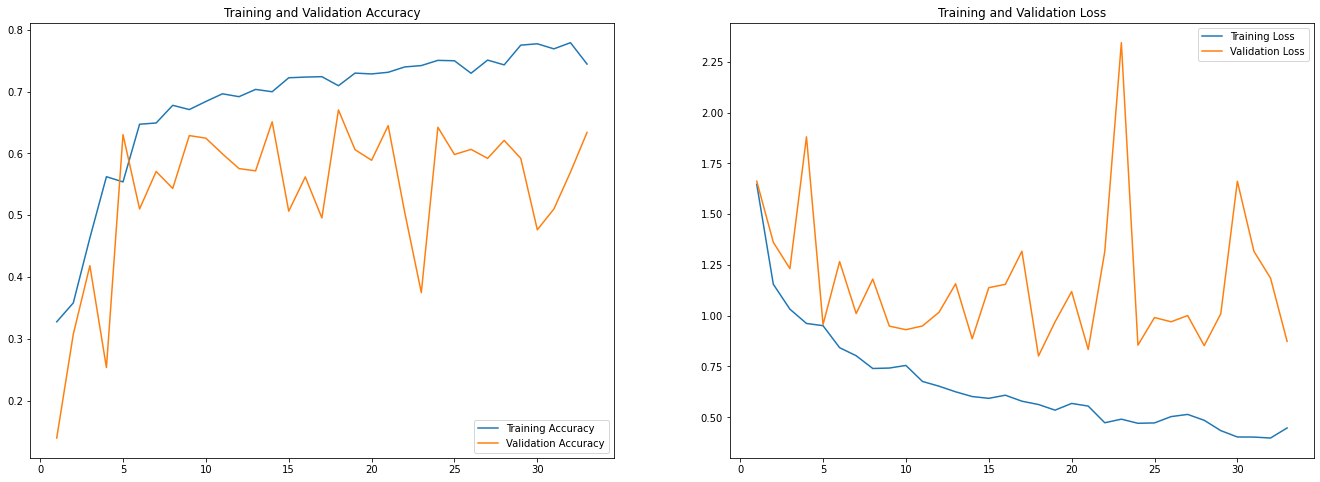

In [11]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

metrics = history6.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
from sklearn.metrics import classification_report,confusion_matrix
predictions1=model.predict(valid_generator,steps=len(valid_generator))
y=np.argmax(predictions1,axis=1)

print('Classification Report')
cr=classification_report(y_true=valid_generator.classes,y_pred=y,target_names=valid_generator.class_indices)
print(cr)
evaluates=model.evaluate(valid_generator)
print(evaluates)

Classification Report
              precision    recall  f1-score   support

  BCC_images       0.50      0.44      0.47       996
  BKL_images       0.40      0.32      0.35       787
   DF_images       0.05      0.14      0.07        71
 VASC_images       0.03      0.11      0.05        75

    accuracy                           0.36      1929
   macro avg       0.25      0.25      0.24      1929
weighted avg       0.43      0.36      0.39      1929



/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


121/121 [==============================] - 60s 495ms/step - loss: 0.8737 - accuracy: 0.6340
[0.8737062811851501, 0.6340072751045227]


Confusion Matrix


<AxesSubplot:>

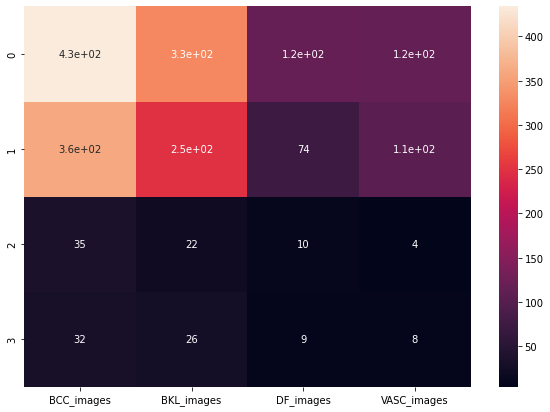

In [13]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes,y)
df = pd.DataFrame(cm,columns=valid_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df,annot=True)

In [14]:
y_pred = model.predict(test_generator)
y_pred

/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


array([[5.76050989e-02, 2.08684281e-01, 1.60734126e-05, 7.33694553e-01],
       [2.95043975e-01, 3.87121975e-01, 1.26588553e-01, 1.91245556e-01],
       [1.12290785e-01, 8.85957122e-01, 1.71604479e-04, 1.58048910e-03],
       ...,
       [3.87040019e-01, 6.12911761e-01, 3.64937223e-05, 1.17007485e-05],
       [1.17627554e-01, 8.00132871e-01, 8.16328302e-02, 6.06755493e-04],
       [7.55663872e-01, 2.44138464e-01, 1.89482977e-04, 8.26174164e-06]],
      dtype=float32)